In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict


class SimpleSpatialSplitter:
    """
    A simple spatial-aware splitter that maintains polygon integrity
    while aiming for approximate size balance.
    """
    def __init__(self, test_size=0.2, random_state=None):
        self.test_size = test_size
        self.random_state = random_state
        np.random.seed(random_state)
    
    def split_positives(self, positives_df, polygon_id_col):
        """Split positive samples keeping polygons intact."""
        # Get polygon sizes
        polygon_sizes = positives_df.groupby(polygon_id_col).size()
        total_samples = polygon_sizes.sum()
        
        # Shuffle polygon IDs
        polygon_ids = list(polygon_sizes.index)
        np.random.shuffle(polygon_ids)
        
        # Assign polygons to train/test
        test_polygons = []
        test_count = 0
        target_test = total_samples * self.test_size
        
        # Keep adding polygons to test until we reach approximate target
        for pid in polygon_ids:
            if test_count < target_test:
                test_polygons.append(pid)
                test_count += polygon_sizes[pid]
            
        # Create masks
        train_mask = ~positives_df[polygon_id_col].isin(test_polygons)
        test_mask = positives_df[polygon_id_col].isin(test_polygons)
        
        return np.where(train_mask)[0], np.where(test_mask)[0]
    
    def split(self, X, y, polygon_id_col=None, class_col=None):
        """Perform the complete train-test split."""
        positives_mask = y == 1
        negatives_mask = y == 0
        
        # Split positive samples by polygon
        pos_train_idx, pos_test_idx = self.split_positives(
            X[positives_mask].reset_index(drop=True),
            polygon_id_col
        )
        
        # Split negative samples with stratification if class_col provided
        neg_train_idx, neg_test_idx = train_test_split(
            np.arange(negatives_mask.sum()),
            test_size=self.test_size,
            stratify=X[negatives_mask][class_col] if class_col else None,
            random_state=self.random_state
        )
        
        # Combine indices
        all_pos_idx = np.where(positives_mask)[0]
        all_neg_idx = np.where(negatives_mask)[0]
        
        train_idx = np.concatenate([
            all_pos_idx[pos_train_idx],
            all_neg_idx[neg_train_idx]
        ])
        test_idx = np.concatenate([
            all_pos_idx[pos_test_idx],
            all_neg_idx[neg_test_idx]
        ])
        
        return X.iloc[train_idx], X.iloc[test_idx], y[train_idx], y[test_idx]
    
BUFFER_SIZE = 160
detections_with_polygons = gpd.read_parquet(
    f"gs://demeter-labs/tea/ei-datasets/tile_geom_farm_id_pos_gdf_v2_java_sumatra_2024-11-11_buffer{BUFFER_SIZE}.parquet")
embeddings = gpd.read_parquet(
    "gs://demeter-labs/tea/classifier-datasets/tile_classifier_dataset_v2_java-sumatra_embeddings.parquet")
polygon_id_embedding_merged = embeddings.merge(detections_with_polygons[['tile_id', 'polygon_id']], on='tile_id', how='left')
polygon_id_embedding_merged['polygon_id'].value_counts()

ArrowInvalid: google::cloud::Status(INVALID_ARGUMENT: Permanent error, with a last message of Could not create a OAuth2 access token to authenticate the request. The request was not sent, as such an access token is required to complete the request successfully. Learn more about Google Cloud authentication at https://cloud.google.com/docs/authentication. The underlying error message was: {
  "error": "invalid_grant",
  "error_description": "reauth related error (invalid_rapt)",
  "error_uri": "https://support.google.com/a/answer/9368756",
  "error_subtype": "invalid_rapt"
} error_info={reason=, domain=, metadata={gcloud-cpp.retry.function=GetObjectMetadata, gcloud-cpp.retry.reason=permanent-error, gcloud-cpp.retry.original-message=Could not create a OAuth2 access token to authenticate the request. The request was not sent, as such an access token is required to complete the request successfully. Learn more about Google Cloud authentication at https://cloud.google.com/docs/authentication. The underlying error message was: {
  "error": "invalid_grant",
  "error_description": "reauth related error (invalid_rapt)",
  "error_uri": "https://support.google.com/a/answer/9368756",
  "error_subtype": "invalid_rapt"
}}}). Detail: [errno 22] Invalid argument

[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232729175/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232729175/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/christopher.x.ren/miniforge3/envs/ei-nb-v2/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:37:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1730232729175/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.wa

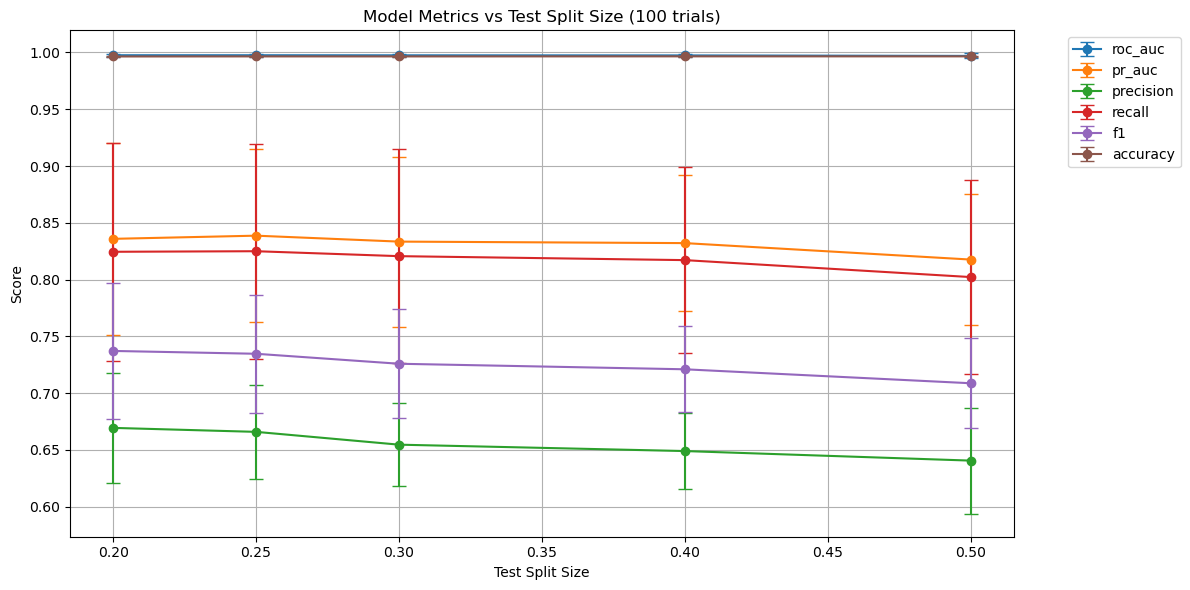

In [8]:
import xgboost
from sklearn import metrics
from joblib import Parallel, delayed


feature_cols = [col for col in polygon_id_embedding_merged.columns if 'vit' in col]
input_cols = ['polygon_id', 'class'] + feature_cols
X = polygon_id_embedding_merged[input_cols]
y = polygon_id_embedding_merged['label']

test_splits = [0.2, 0.25, 0.3, 0.4, 0.5]
n_trials = 50

def run_trial(test_size, trial):
    model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    splitter = SimpleSpatialSplitter(test_size=test_size, random_state=trial)
    X_train, X_test, y_train, y_test = splitter.split(
        X=X,
        y=y,
        polygon_id_col='polygon_id',
        class_col='class'
    )
    
    # Calculate class weights
    class_weights = dict(zip(
        *np.unique(y_train, return_counts=True)
    ))
    sample_weights = np.array([class_weights[label] for label in y_test])
    
    # Train model
    model.fit(X_train[feature_cols], y_train)
    y_pred = model.predict(X_test[feature_cols])
    y_pred_proba = model.predict_proba(X_test[feature_cols])[:, 1]
    
    # Calculate metrics with sample weights
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, sample_weight=sample_weights)
    precision_curve, recall_curve, _ = metrics.precision_recall_curve(
        y_test, y_pred_proba, sample_weight=sample_weights
    )
    
    return {
        'test_size': test_size,
        'trial': trial,
        'roc_auc': metrics.roc_auc_score(y_test, y_pred_proba, sample_weight=sample_weights),
        'pr_auc': metrics.auc(recall_curve, precision_curve),
        'precision': metrics.precision_score(y_test, y_pred, sample_weight=sample_weights),
        'recall': metrics.recall_score(y_test, y_pred, sample_weight=sample_weights),
        'f1': metrics.f1_score(y_test, y_pred, sample_weight=sample_weights),
        'accuracy': metrics.accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    }

results = Parallel(n_jobs=25, verbose=10)(
    delayed(run_trial)(test_size, trial)
    for test_size in test_splits
    for trial in range(n_trials)
)

# Reorganize results
metrics_dict = {split: [] for split in test_splits}
for trial_result in results:
    metrics_dict[trial_result['test_size']].append({
        k:v for k,v in trial_result.items() if k not in ['test_size', 'trial']
    })

# Calculate means and standard deviations
mean_metrics = []
std_metrics = []

for test_size in test_splits:
    trial_df = pd.DataFrame(metrics_dict[test_size])
    mean_metrics.append({
        'test_split': test_size,
        **trial_df.mean().to_dict()
    })
    std_metrics.append(trial_df.std().to_dict())

# Create DataFrames
df_mean = pd.DataFrame(mean_metrics).set_index('test_split')
df_std = pd.DataFrame(std_metrics, index=test_splits)

# Plot with error bars
plt.figure(figsize=(12, 6))
for column in df_mean.columns:
    plt.errorbar(test_splits, df_mean[column], yerr=df_std[column], 
                marker='o', label=column, capsize=5)

plt.title('Model Metrics vs Test Split Size (100 trials)')
plt.xlabel('Test Split Size')
plt.ylabel('Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


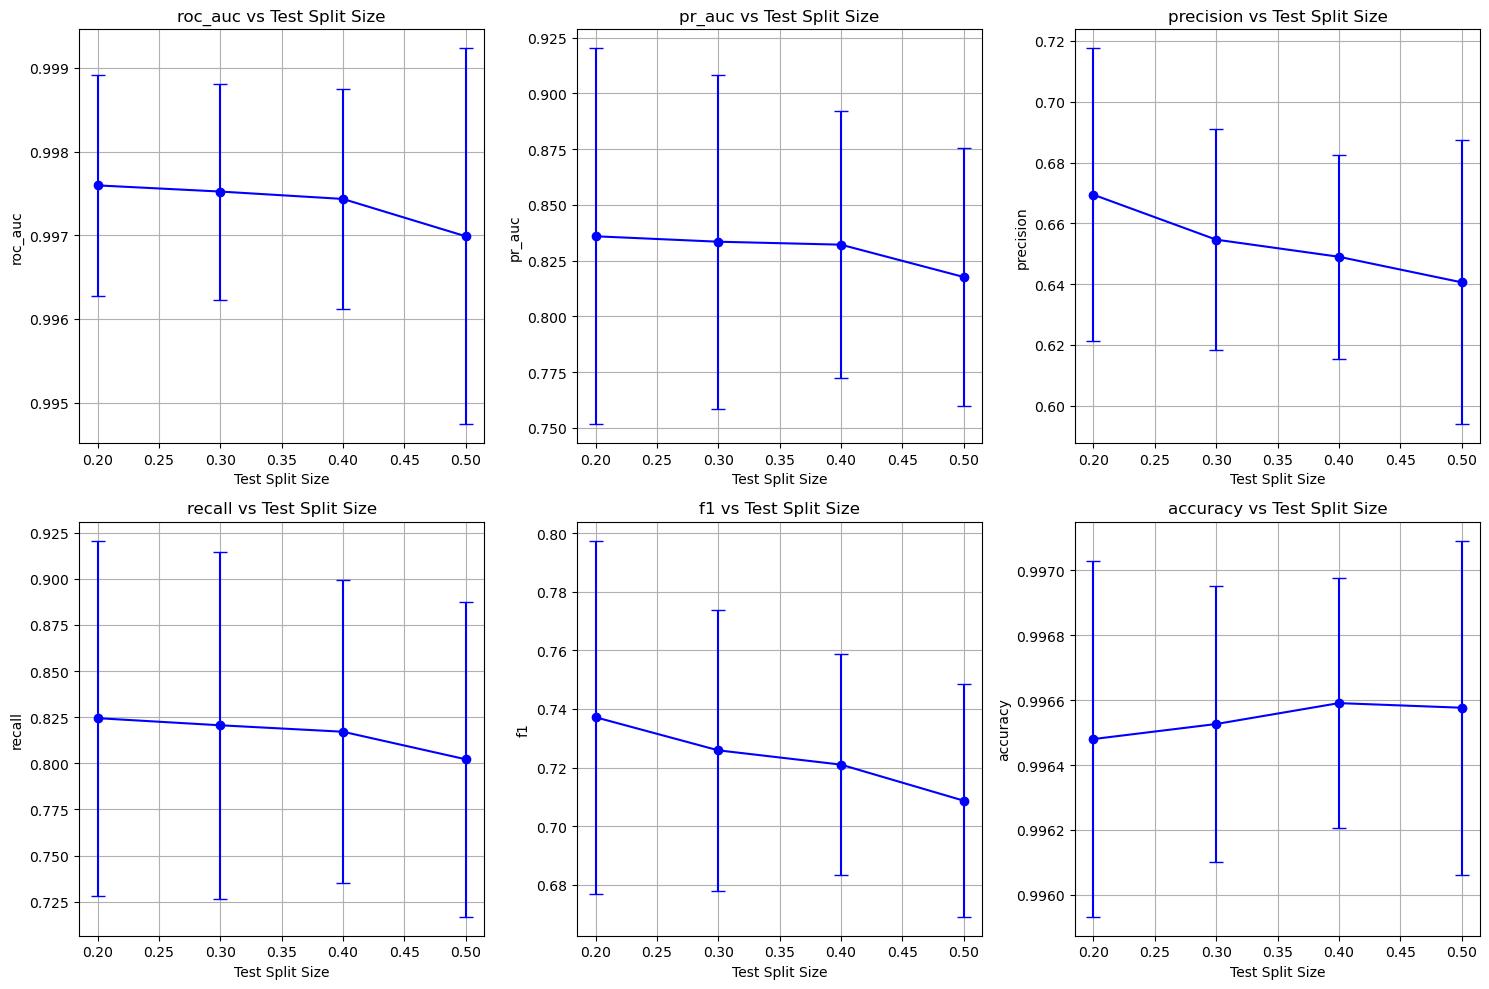

In [13]:
# Create separate plots for each metric
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

plot_splits = [0.2, 0.3, 0.4, 0.5]

for idx, column in enumerate(df_mean.columns):
    axes[idx].errorbar(plot_splits, df_mean.loc[plot_splits, column], yerr=df_std.loc[plot_splits, column],
                      marker='o', capsize=5, color='blue')
    axes[idx].set_title(f'{column} vs Test Split Size')
    axes[idx].set_xlabel('Test Split Size')
    axes[idx].set_ylabel(column)
    axes[idx].grid(True)

# # Hide the empty subplot
# axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('spatial_stratification_metrics.png', dpi=300)